In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
import warnings
import numpy as np
import cv2,os
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
PATH = ""

train_dir = os.path.join(PATH, 'train_images')

BATCH_SIZE = 16
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            validation_split=0.2,
                                                            subset="training",
                                                            shuffle=True,
                                                            seed=123,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset= tf.keras.utils.image_dataset_from_directory(train_dir,
                                                                validation_split=0.2,
                                                                subset="validation",
                                                                shuffle=True,
                                                                seed=123,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE)
# check all classes in our data
class_names = train_dataset.class_names
print(class_names)

Found 755 files belonging to 5 classes.
Using 604 files for training.
Found 755 files belonging to 5 classes.
Using 151 files for validation.
['A', 'B', 'I', 'K', 'L']


In [4]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of test batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of test batches: 38
Number of validation batches: 8
Number of test batches: 2


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
# Data Augmentation to avoid overfitting
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [7]:
# Create the base model from the pre-trained model Xception
IMG_SHAPE = IMG_SIZE + (3,)
base_model = VGG16(input_shape=IMG_SHAPE,
                      include_top=False,
                      weights='imagenet')

In [8]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 512)


19


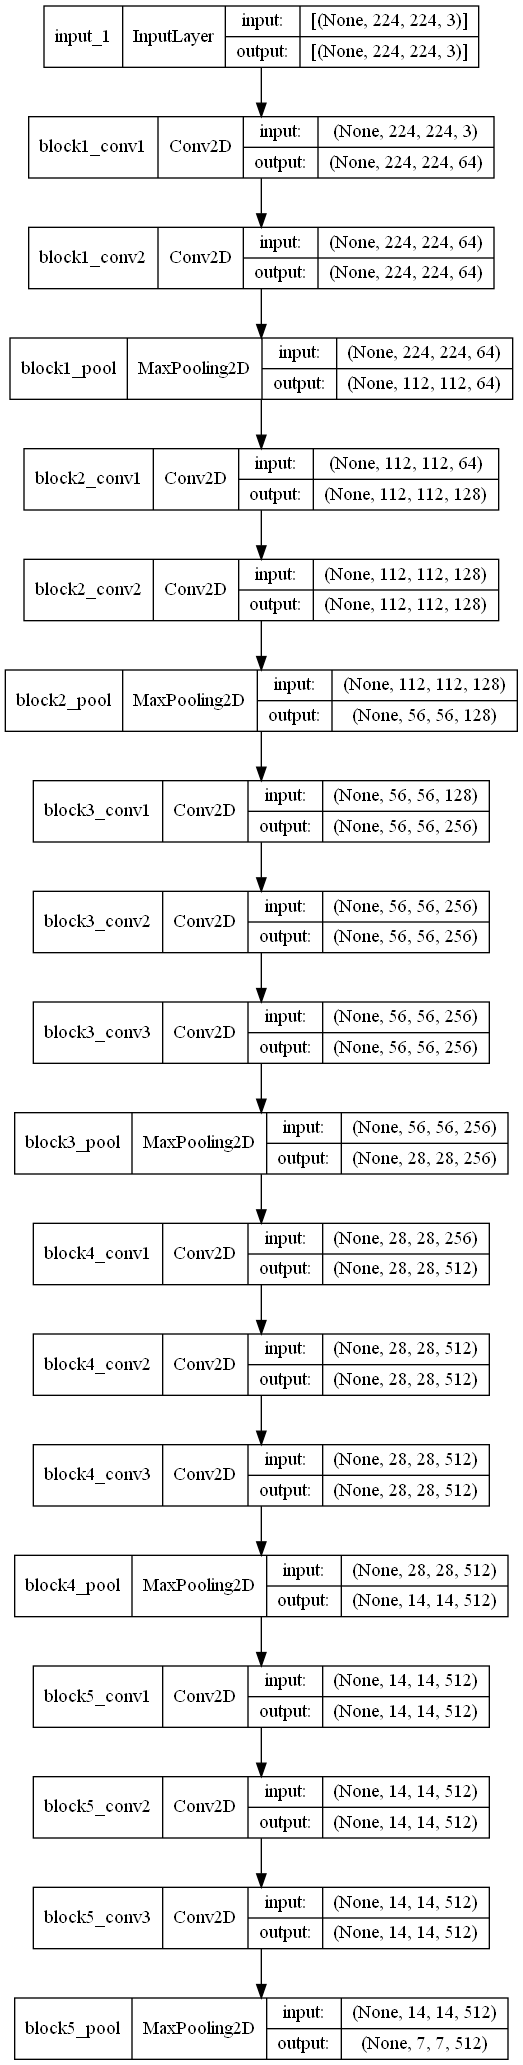

In [9]:
base_model.trainable = False
# print number of layer in the base model
print(len(base_model.layers))

tf.keras.utils.plot_model(
    base_model, show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=False
)

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 512)


In [11]:
input_shape=list(IMG_SIZE)
input_shape.append(3)

num_classes = len(class_names)
model_head = Sequential([
  layers.Conv2D(256, 17, padding='same', activation='sigmoid'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 9, padding='same', activation='relu'),
  layers.Conv2D(64, 7, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='selu'),
])
model_head1 = Sequential([
  layers.Dense(128, activation='sigmoid'),
  layers.Dense(32, activation='gelu'),
  layers.Dense(num_classes)
])


In [12]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = model_head(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.22)(x)
outputs = model_head1(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
model.compile(  optimizer=Adam(learning_rate=0.001, amsgrad=True), 
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                metrics=['accuracy'])


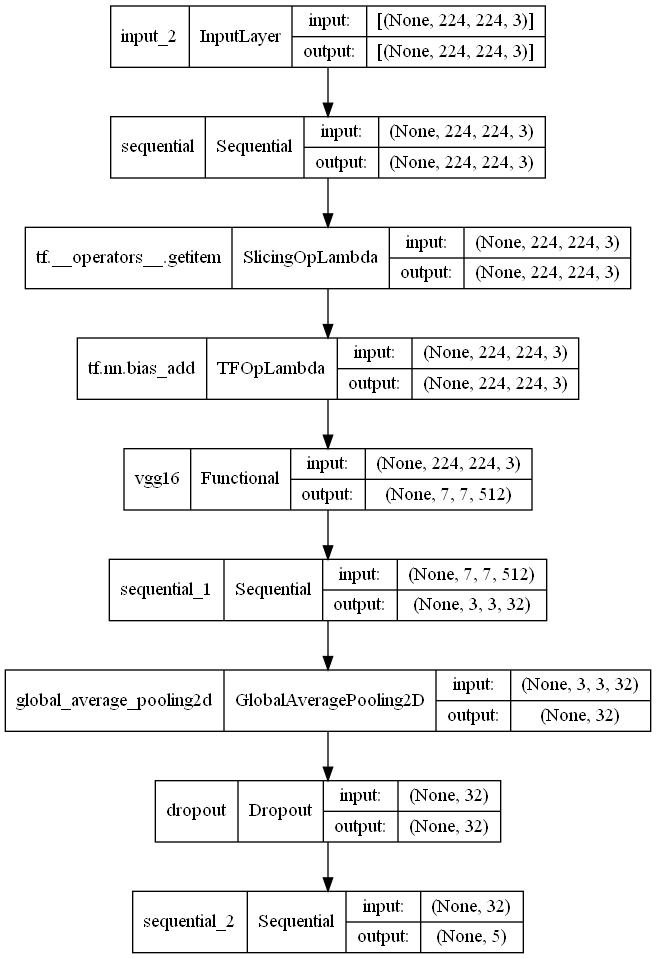

In [14]:
# Plot model architecture
tf.keras.utils.plot_model(
    model, show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=True
)

In [15]:
fine_tune_epochs = 35
initial_epochs = 30
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000005)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(train_dataset, epochs=initial_epochs, callbacks=[reduce_lr, early_stop],  validation_data =validation_dataset)#, checkpoint])


Epoch 1/30
38/38 [==============================] - 12s 219ms/step - loss: 1.4983 - accuracy: 0.3179 - val_loss: 1.0361 - val_accuracy: 0.5966 - lr: 0.0010
Epoch 2/30
38/38 [==============================] - 4s 104ms/step - loss: 0.7753 - accuracy: 0.6805 - val_loss: 0.3962 - val_accuracy: 0.9328 - lr: 0.0010
Epoch 3/30
38/38 [==============================] - 4s 101ms/step - loss: 0.6546 - accuracy: 0.6921 - val_loss: 0.3607 - val_accuracy: 0.8151 - lr: 0.0010
Epoch 4/30
38/38 [==============================] - 4s 102ms/step - loss: 0.3419 - accuracy: 0.8543 - val_loss: 0.1660 - val_accuracy: 0.9748 - lr: 0.0010
Epoch 5/30
38/38 [==============================] - 4s 103ms/step - loss: 0.1750 - accuracy: 0.9603 - val_loss: 0.4410 - val_accuracy: 0.8739 - lr: 0.0010
Epoch 6/30
38/38 [==============================] - 4s 102ms/step - loss: 0.1459 - accuracy: 0.9586 - val_loss: 0.0466 - val_accuracy: 0.9916 - lr: 0.0010
Epoch 7/30
38/38 [==============================] - 4s 102ms/step - l

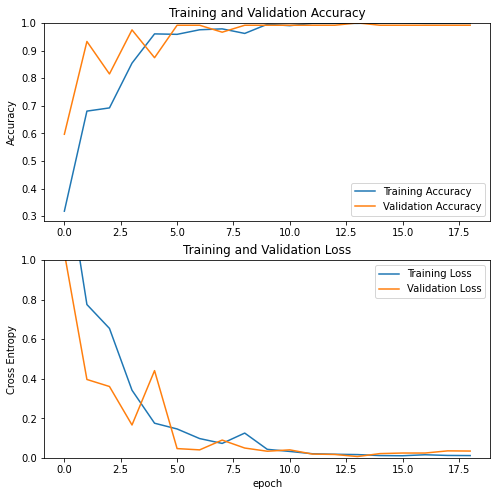

max validation accuracy before fine tuning is 1.00000


In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
print("max validation accuracy before fine tuning is %.5f"%max(val_acc))

In [17]:
model.save('trained_models/TL_VGG16.h5')

In [18]:
# Load the model
loaded_model= tf.keras.models.load_model('trained_models/TL_VGG16.h5')

In [19]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = loaded_model.predict_on_batch(image_batch)

print('Predictions Shape:\n', predictions.shape)
scores =[tf.nn.softmax(prediction) for prediction in predictions]
label_predict=np.array([np.argmax(score) for score in scores])
print('label predict \n', label_predict)

print('Labels:\n', label_batch)

Predictions Shape:
 (16, 5)
label predict 
 [2 1 1 2 0 2 3 4 2 1 1 1 1 2 2 2]
Labels:
 [2 1 1 2 0 2 3 4 2 1 1 1 1 2 2 2]
